---
title: 00 - Figures (common)
author: [Martin Proks, Nazmus Salehin]
date: 25-10-2023
---

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import scvi
from scvi.model import SCANVI
from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import cellrank as cr
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", category=UserWarning)

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%run ../scripts/helpers.py

In [92]:
def get_symbol(features: list[str]) -> np.ndarray:
    ENSG_to_SYMBOL = pd.read_csv('../data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL.tsv', delimiter=" ", header=None)
    ENSG_to_SYMBOL.columns = ['ensembl','symbol']
    ENSG_to_SYMBOL_noName = pd.read_csv('../data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL_noName.tsv', delimiter=" ", header=None)
    nameless_df = pd.DataFrame(
        data = {
            'ensembl' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
            'symbol' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
        })
    ENSG_to_SYMBOL = pd.concat([ENSG_to_SYMBOL, nameless_df])
    ENSG_to_SYMBOL.set_index('ensembl', inplace=True)

    df = pd.DataFrame(features, index=features, columns=['symbol'])
    common_genes = features.intersection(ENSG_to_SYMBOL.index)
    df.loc[common_genes, 'symbol'] = ENSG_to_SYMBOL.loc[common_genes, 'symbol']

    return df.symbol.values

In [4]:
mouse_ct_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61'
}

human_ct_colors = {
    'Prelineage': '#7985A5',
    '8C_3.0': '#028A46',
    'Morula_4.0': '#657cbd',
    'Inner Cell Mass': '#F6C445',
    'Primitive Endoderm': '#D05B61',
    'Epiblast_6.0': '#d6b2ca',
    'Epiblast_7.0': '#c38db1',
    'Late epiblast': '#aa5c8f',
    'Trophectoderm_5.0': '#cddff0',
    'Trophectoderm_6.0': '#bdd4eb',
    'Trophectoderm_7.0': '#acc9e6',
    'Trophectoderm_8.0': '#9cbfe2',
    'Trophectoderm_9.0': '#8bb4dd',
    'Trophectoderm_10.0': '#5a94ce',
    'Unknown': '#F1BD93',
}

In [6]:
sc.settings.figdir = '../figures/'
sc.set_figure_params(dpi=120, dpi_save = 300, format='svg', transparent=True, figsize=(6,5))

In [6]:
mouse = sc.read("../results/03_mouse.processed.h5ad")
mouse.obs.stage = mouse.obs.stage.astype('category').cat.reorder_categories(['Zygote', '2C', '4C', '8C', '16C', 'ICM', 'TE', 'EPI', 'PrE'])

In [7]:
human = sc.read('../results/02_human_integration/05_scanvi_ns15/adata.h5ad')
human.obs.C_scANVI_nsamples = human.obs.C_scANVI_nsamples.astype('category')
human.obs.C_scANVI_nsamples = human.obs.C_scANVI_nsamples.cat.reorder_categories(list(human_ct_colors.keys())[:-1], ordered=True)

## QC

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=[20, 4])

qc_human = sc.read("../data/processed/32_human_adata.h5ad")

sc.pl.violin(mouse, 'n_genes_by_counts', jitter=0.4, show=False, ax=ax[0])
sc.pl.violin(mouse, 'total_counts', jitter=0.4, show=False, ax=ax[1], c='black')
sc.pl.violin(qc_human, 'n_genes', jitter=0.4, show=False, ax=ax[2])
sc.pl.violin(qc_human, 'n_counts', jitter=0.4, show=False, ax=ax[3])

fig.tight_layout()

## Suppl. Table 1 (autotune)

In [ ]:
mouse_autotune = pd.read_csv("../results/02_mouse_integration/tunning.csv", index_col=0)
mouse_autotune['0'] = mouse_autotune['0'].fillna(0)
mouse_autotune['1'] = mouse_autotune['1'].str.replace('gene_likelihood=', '')
mouse_autotune['2'] = mouse_autotune['2'].str.replace('lr=', '')
mouse_autotune['3'] = mouse_autotune['3'].str.replace('n_hidden=', '')
mouse_autotune['4'] = mouse_autotune['4'].str.replace('n_layers=', '').str.split('_', expand=True)[0]
mouse_autotune.columns=['Validation loss', 'Distribution', 'Learning Rate', 'Num. of layers', 'Num. of hidden layers']

human_autotune = pd.read_csv("../results/02_human_integration/tunning.csv", index_col=0)
human_autotune['0'] = human_autotune['0'].fillna(0)
human_autotune['1'] = human_autotune['1'].str.replace('gene_likelihood=', '')
human_autotune['2'] = human_autotune['2'].str.replace('lr=', '')
human_autotune['3'] = human_autotune['3'].str.replace('n_hidden=', '')
human_autotune['4'] = human_autotune['4'].str.replace('n_layers=', '').str.split('_', expand=True)[0]
human_autotune.columns=['Validation loss', 'Distribution', 'Learning Rate', 'Num. of layers', 'Num. of hidden layers']

writer = pd.ExcelWriter("../results/suppl-tab-1.xlsx", engine="xlsxwriter")
mouse_autotune.to_excel(writer, sheet_name="mouse")
human_autotune.to_excel(writer, sheet_name="human")
writer.close()

## Stats

In [ ]:
mouse.obs['stats'] = mouse.obs.stage

human.obs.experiment = human.obs.experiment.str.replace('_', ' et al., ').astype('category')
human.obs['stats'] = human.obs['ct'].cat.rename_categories({
    'Epiblast': 'EPI', 'Inner Cell Mass': 'ICM',
    'Morula': '16C', 'Primitive Endoderm': 'PrE',
    'Trophectoderm': 'TE'
})

In [ ]:
pub_stats = pd.concat([
    mouse.obs.groupby(['experiment', 'stats']).apply(len).unstack().fillna(0).pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index]),
    human.obs.groupby(['experiment', 'stats']).apply(len).unstack().fillna(0).pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index])
])
pub_stats.sum(axis=1).plot(kind='bar', color='grey')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xticks(rotation=45, ha='right')
plt.legend('', frameon=False)
_ = plt.ylabel('Publications')
_ = plt.xlabel('Number of cells')
# plt.savefig("../figures/cells_per_publication.svg")

In [ ]:
pub_stats = pd.concat([
    human.obs.groupby(['experiment', 'stats']).apply(len).unstack().fillna(0).pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index]),
    mouse.obs.groupby(['experiment', 'stats']).apply(len).unstack().fillna(0).pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index]),
])
pub_colors = np.concatenate([np.repeat('black', human.obs.experiment.cat.categories.size), np.repeat('grey', mouse.obs.experiment.cat.categories.size)])
pub_stats.sum(axis=1).plot(kind='barh', color=pub_colors)
plt.gca().spines[['right', 'top']].set_visible(False)
_ = plt.ylabel('Publications')
_ = plt.xlabel('Number of cells')
# plt.savefig("../figures/cells_per_publication.svg")

In [ ]:
pub_stats = pd.concat([
    human.obs.groupby(['experiment', 'stats']).apply(len).unstack().fillna(0).pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index]),
    mouse.obs.groupby(['experiment', 'stats']).apply(len).unstack().fillna(0).pipe(lambda df: df.loc[df.sum(axis=1).sort_values(ascending=False).index]),
])

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 1]})
pub_colors = np.concatenate([np.repeat('black', human.obs.experiment.cat.categories.size-1), np.repeat('grey', mouse.obs.experiment.cat.categories.size-1)])
pub_stats[~pub_stats.index.isin(['Nowotschin et al., 2019', 'Petropoulos et al., 2016'])].sum(axis=1).plot(kind='barh', color=pub_colors, ax=ax[0])
ax[0].spines[['right', 'top']].set_visible(False)
_ = ax[0].set_ylabel('')

pub_stats.loc[['Petropoulos et al., 2016', 'Nowotschin et al., 2019']].sum(axis=1).plot(kind='barh', color=['black', 'grey'], ax=ax[1])
plt.gca().spines[['right', 'top']].set_visible(False)
_ = ax[1].set_ylabel('')

fig.supxlabel('Number of cells')
fig.supylabel('Experiments')
fig.tight_layout()

# plt.savefig("../figures/cells_per_publication.svg")

<Axes: xlabel='experiment', ylabel='technology'>

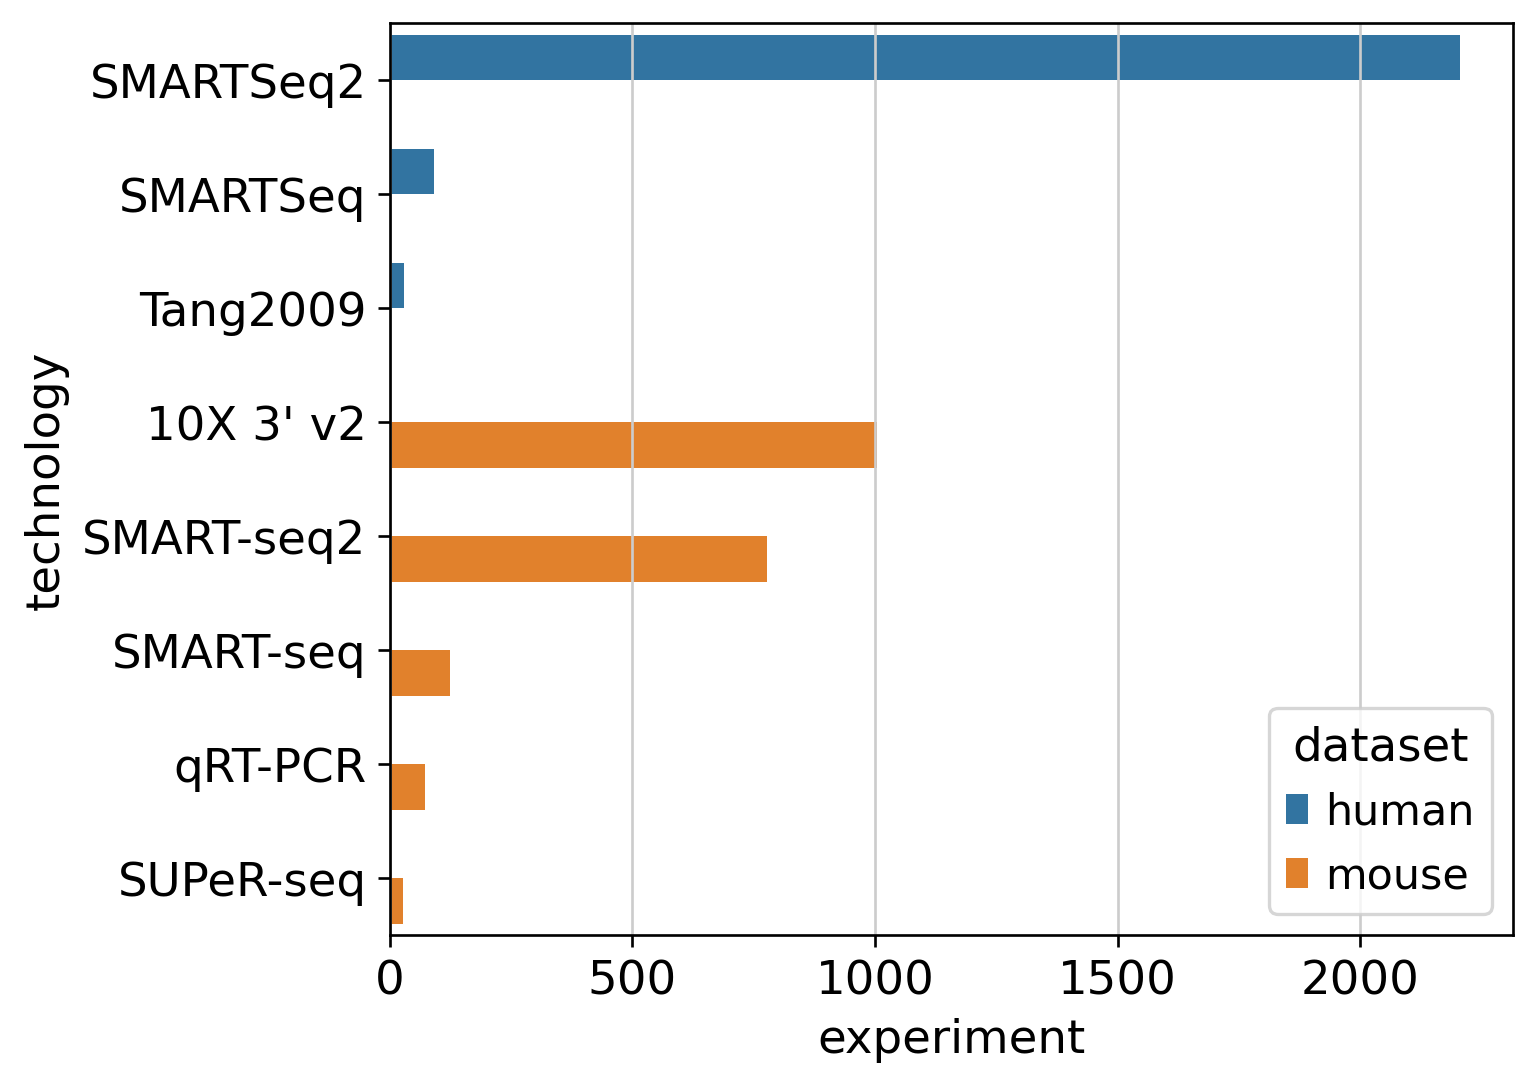

In [34]:
sns.barplot(x='experiment', y='technology', hue='dataset', data=technology_stats.reset_index())

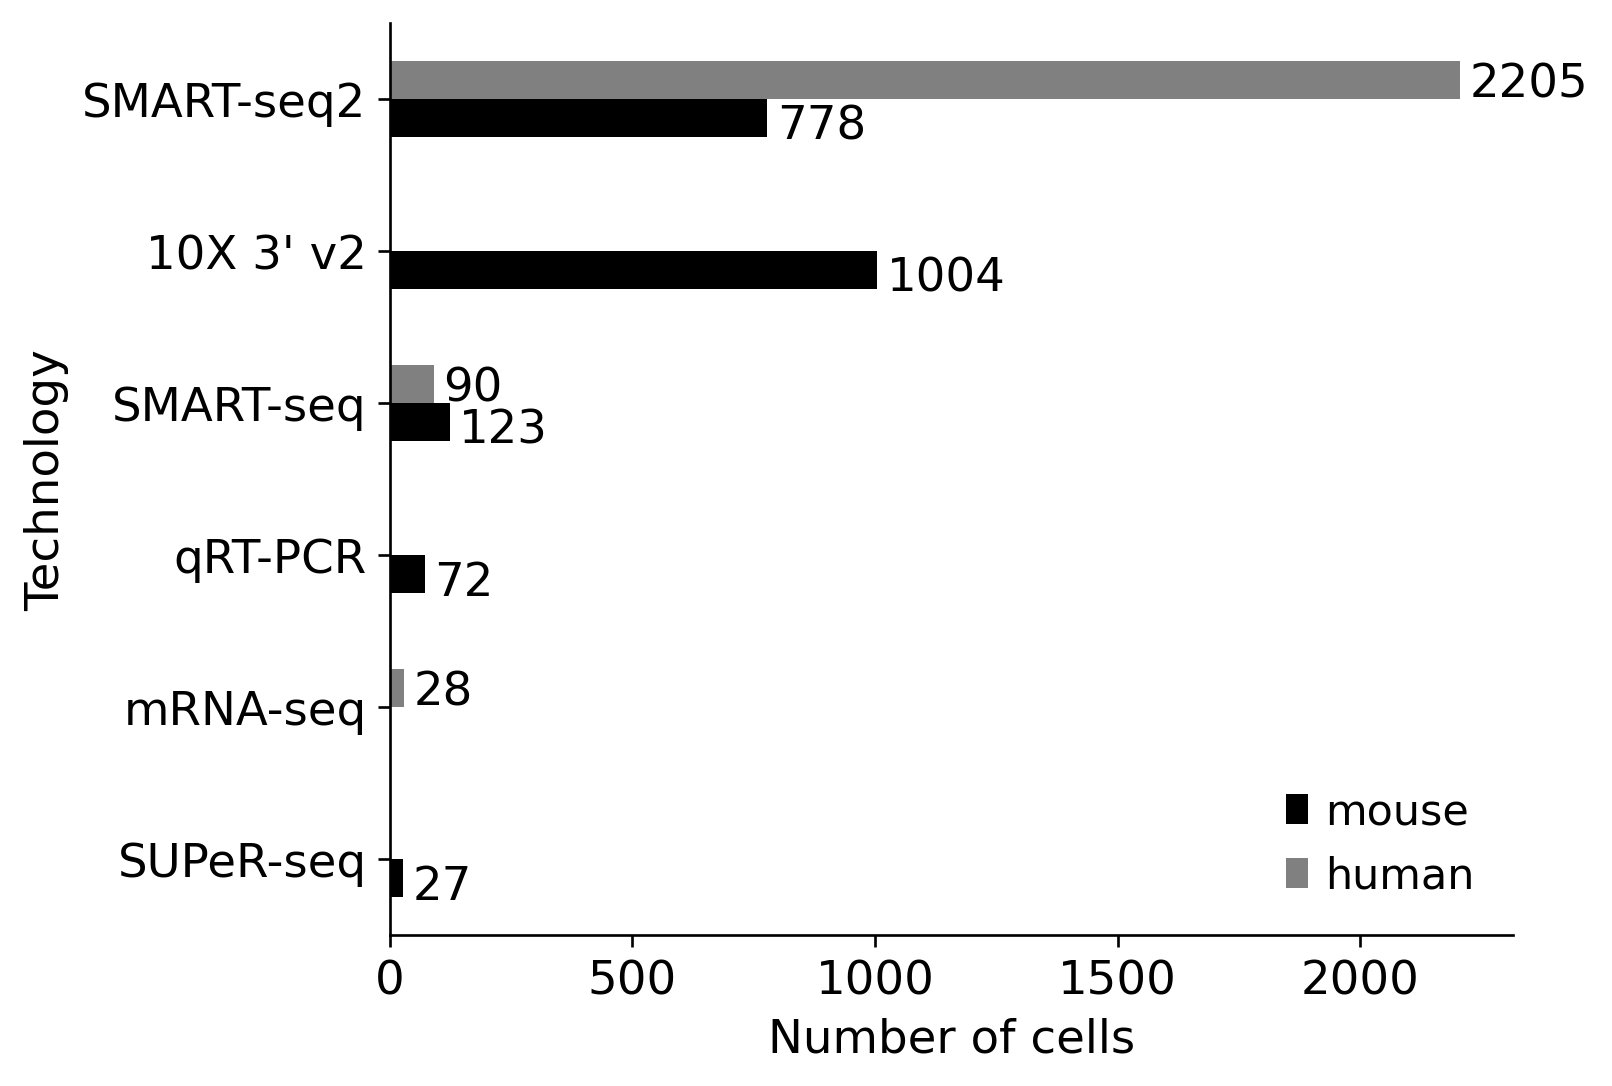

In [149]:
human.obs.technology = human.obs.technology.cat.rename_categories(['SMART-seq', 'SMART-seq2', 'mRNA-seq'])
technology_stats = mouse.obs.groupby('technology').count()[['experiment']].rename(columns={"experiment": "mouse"}).merge(
    human.obs.groupby('technology').count()[['experiment']].rename(columns={"experiment": "human"}), 
    how='outer', left_index=True, right_index=True).fillna(0).loc[["SUPeR-seq", "mRNA-seq", "qRT-PCR", "SMART-seq", "10X 3' v2", "SMART-seq2"]]

technology_stats.plot(kind='barh', color=['black', 'grey'])
for idx, row in technology_stats.reset_index().iterrows():
    if row['mouse'] != 0:
        plt.annotate(str(int(row['mouse'])), xy=(row['mouse'] + 20, idx - 0.18), va='center')
    if row['human'] != 0:
        plt.annotate(str(int(row['human'])), xy=(row['human'] + 20, idx + 0.1), va='center')

plt.gca().spines[['right', 'top']].set_visible(False)
plt.legend(loc='lower right', frameon=False)
plt.grid(False)
_ = plt.ylabel('Technology')
_ = plt.xlabel('Number of cells')
plt.savefig("../figures/stats_technology.svg")

In [ ]:
# experiment_stats = mouse.obs.groupby(['experiment', 'stage']).apply(len).unstack().fillna(0).iloc[::-1]
# experiment_stats.plot(kind='barh', stacked=True)

# for y, x in enumerate(experiment_stats.sum(axis=1).astype(int)):
#     plt.annotate(str(x), xy=(x + 10, y), va='center')

# plt.gca().spines[['right', 'top']].set_visible(False)
# plt.xticks(rotation=45, ha='right')
# plt.gca().legend(frameon=False)
# _ = plt.ylabel('Publications')
# _ = plt.xlabel('Number of cells')

## scANVI ns[15] mouse and human

In [ ]:
lvae_mouse = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")
lvae_human = scvi.model.SCANVI.load("../results/02_human_integration/05_scanvi_ns15/")

In [ ]:
lvae_mouse.adata.obsm['X_scANVI'] = lvae_mouse.get_latent_representation()
lvae_human.adata.obsm['X_scANVI'] = lvae_human.get_latent_representation()

In [ ]:
lvae_mouse.adata.obs["predictions"] = lvae_mouse.predict()
lvae_mouse.adata.obs.predictions = lvae_mouse.adata.obs.predictions.astype('category')
lvae_mouse.adata.obs['entropy'] = 1 - lvae_mouse.predict(soft=True).max(axis=1)

lvae_human.adata.obs["predictions"] = lvae_human.predict()
lvae_human.adata.obs.predictions = lvae_human.adata.obs.predictions.astype('category')
lvae_human.adata.obs['entropy'] = 1 - lvae_human.predict(soft=True).max(axis=1)

In [ ]:
sc.pp.neighbors(lvae_mouse.adata, use_rep='X_scANVI')
sc.tl.diffmap(lvae_mouse.adata)
sc.tl.paga(lvae_mouse.adata, groups='predictions')
sc.pl.paga(lvae_mouse.adata)
sc.tl.draw_graph(lvae_mouse.adata, init_pos='paga', n_jobs=10)

sc.pp.neighbors(lvae_human.adata, use_rep='X_scANVI')
sc.tl.diffmap(lvae_human.adata)
sc.tl.paga(lvae_human.adata, groups='predictions')
sc.pl.paga(lvae_human.adata)
sc.tl.draw_graph(lvae_human.adata, init_pos='paga', n_jobs=10)

In [ ]:
lvae_mouse.adata.obs.predictions = lvae_mouse.adata.obs.predictions.cat.reorder_categories(mouse_ct_colors.keys())
lvae_human.adata.obs.predictions = lvae_human.adata.obs.predictions.cat.reorder_categories(list(human_ct_colors.keys())[:-1])

lvae_mouse.adata.uns['predictions_colors'] = [mouse_ct_colors[ct] for ct in lvae_mouse.adata.obs.predictions.cat.categories]
lvae_human.adata.uns['predictions_colors'] = [human_ct_colors[ct] for ct in lvae_human.adata.obs.predictions.cat.categories]

In [ ]:
sc.pl.draw_graph(lvae_mouse.adata, color='predictions', save="00_mouse_scANVI_ns15.svg")
sc.pl.draw_graph(lvae_human.adata, color='predictions', save="00_human_scANVI_ns15.svg")

## SHAP features of scANVI classifiers

In [ ]:
%run ../scripts/deep_scanvi.py

In [9]:
def get_shap_feature(adata: sc.AnnData, shaps: np.ndarray, clf_name: str, groupby: str = 'ct'):
    """
    Generic helper function to extract SHAP features with their according expected value (weight).
    adata: 
        scRNAseq dataset
    shaps:
        List of shap value (each index represents one cell type classifier)
    clf_name:
        Name of the classifier
    
    """
    result = []
    
    for idx, ct in enumerate(adata.obs[groupby].cat.categories):
        vals = pd.DataFrame(shaps[idx], index=adata.obs_names, columns=adata.var_names)
        vals['ct'] = adata.obs[groupby].cat.codes.values
        vals = vals.query('ct == @idx').iloc[:, :-1]
        
        weights = vals\
            .mean(axis=0)\
            .sort_values(ascending=False)\
            .reset_index()\
            .rename(columns={'index':'feature',0:'weight'})
            # .query('weight > 0.5')
        
        weights['ct'] = adata.obs[groupby].cat.categories[idx]
        result.append(weights)
    
    result = pd.concat(result)
    result['clf'] = clf_name
    
    return result


def run_clf_scanvi(clf, clf_name: str, n: int=10, quantile: float = 0.75, groupby: str = 'ct') -> pd.DataFrame:
    """
    The objective is to gather SHAP features for N iterations. We are interested only
    in features which appear N times, this way these features can be considered as conserved.
    clf:
       SCANVI object
    clf_name:
        name of the classifier
    n:
        Number of iterations
    quantile:
        Quantile cuttoff for weight
    """
    results = []
    
    for i in tqdm(range(n)):
        background_idx, background, test_idx, test = train_test_split_by_group_torch(clf.adata, groupby=groupby)
        shap_values = SCANVIDeep(clf.module, background).shap_values(test)
        weights = get_shap_feature(clf.adata[test_idx], shap_values, clf_name, groupby=groupby)
        weights['iteration'] = i + 1
        results.append(weights)
    res = pd.concat(results)

    # res_means = pd.DataFrame(res.query('weight > 0').groupby(['ct', 'feature']).weight.mean())
    # res_means['n'] = res.query('weight > 0').groupby(['ct', 'feature']).count().loc[res_means.index, 'iteration']
    # res_means = res_means.query('n == @n')
    # res_th = res.query('weight > 0').groupby(['clf', 'ct']).weight.quantile(quantile).unstack().T
    # res_means = pd.merge(res_means.reset_index(), res_th, left_on='ct', right_index=True)
    # res_means = res_means[res_means['weight'] >= res_means[clf_name]]

    return res


def filter_SHAP(ds_file: str, n: int = 10):

    df = pd.read_feather(ds_file).query('weight > 0')
    df.feature = df.feature.str.capitalize()

    filtered = df.groupby(['ct', 'feature']).count()[['iteration']].query('iteration == @n')
    df_subset = df.set_index(['ct', 'feature']).loc[filtered.index].reset_index()
    
    filtered['weight_mean'] = df_subset.groupby(['ct', 'feature']).mean().loc[filtered.index, 'weight']
    filtered['weight_std'] = df_subset.groupby(['ct', 'feature']).std().loc[filtered.index, 'weight']
    filtered['weight_ci_upper'] = filtered.weight_mean + filtered.weight_std
    filtered['weight_ci_lower'] = filtered.weight_mean - filtered.weight_std

    return filtered

### Mouse

In [10]:
# mouse_SHAP_scANVI = run_clf_scanvi(scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/"), 'scANVI_ns15', n=10)
# mouse_SHAP_scANVI.reset_index(drop=True).to_feather("../results/00_mouse_scANVI_deepexplainer.feather")

mouse_SHAP_scANVI = pd.read_feather("../results/00_mouse_scANVI_deepexplainer.feather")

mouse.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(mouse, groupby='ct', n_genes=-1)

mouse_SHAP_all = filter_SHAP("../results/00_mouse_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(-1)\
    .reset_index()\
    .set_index(['ct', 'feature'])\
    .loc[mouse.obs.ct.cat.categories]

mouse_SHAP_top_3 = filter_SHAP("../results/00_mouse_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(3)\
    .reset_index()\
    .set_index(['ct', 'feature'])\
    .loc[mouse.obs.ct.cat.categories]

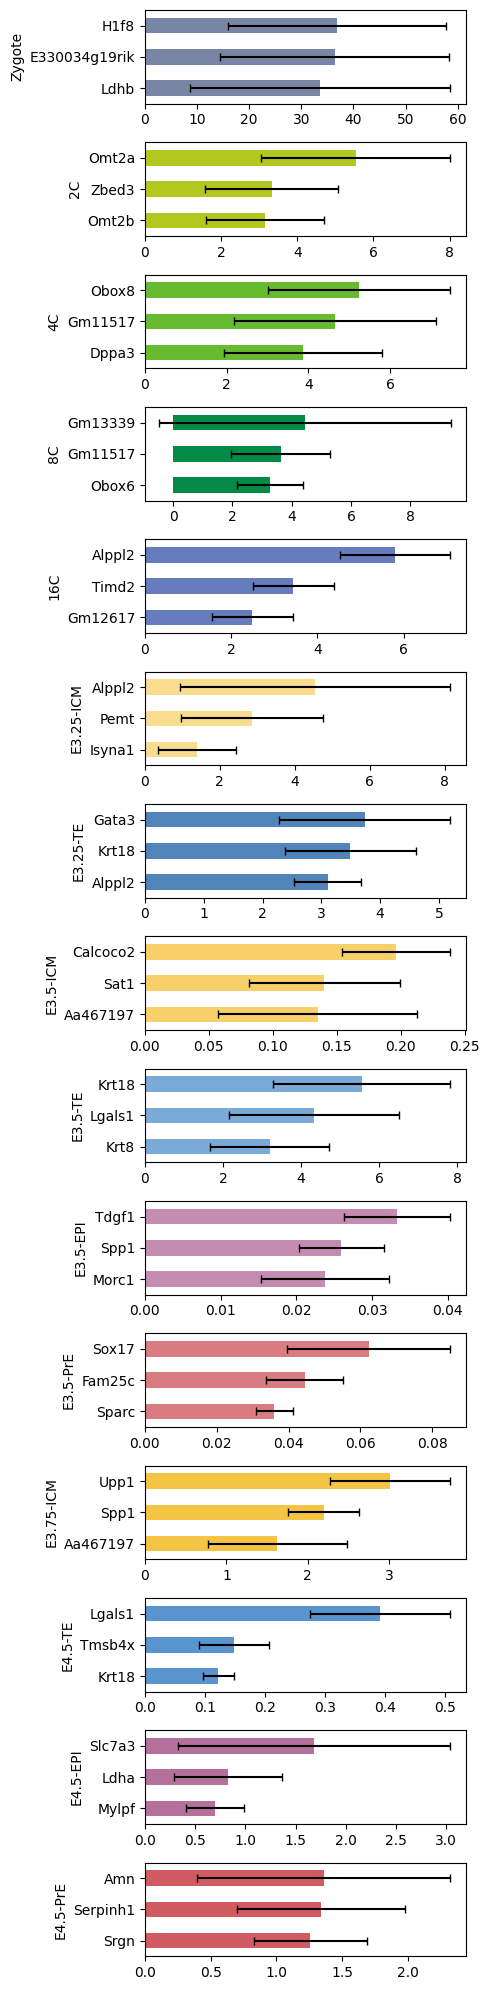

In [11]:
fig, ax = plt.subplots(mouse.obs.ct.cat.categories.size, 1, figsize=[5, 20])
for idx, ct in enumerate(mouse.obs.ct.cat.categories):
    ct_df = mouse_SHAP_top_3.loc[ct].sort_values(by='weight_mean')
    ct_df['weight_mean'].plot.barh(ax=ax[idx], ylabel=ct, xerr=ct_df['weight_std'], color=mouse_ct_colors[ct], capsize=3)
fig.tight_layout()

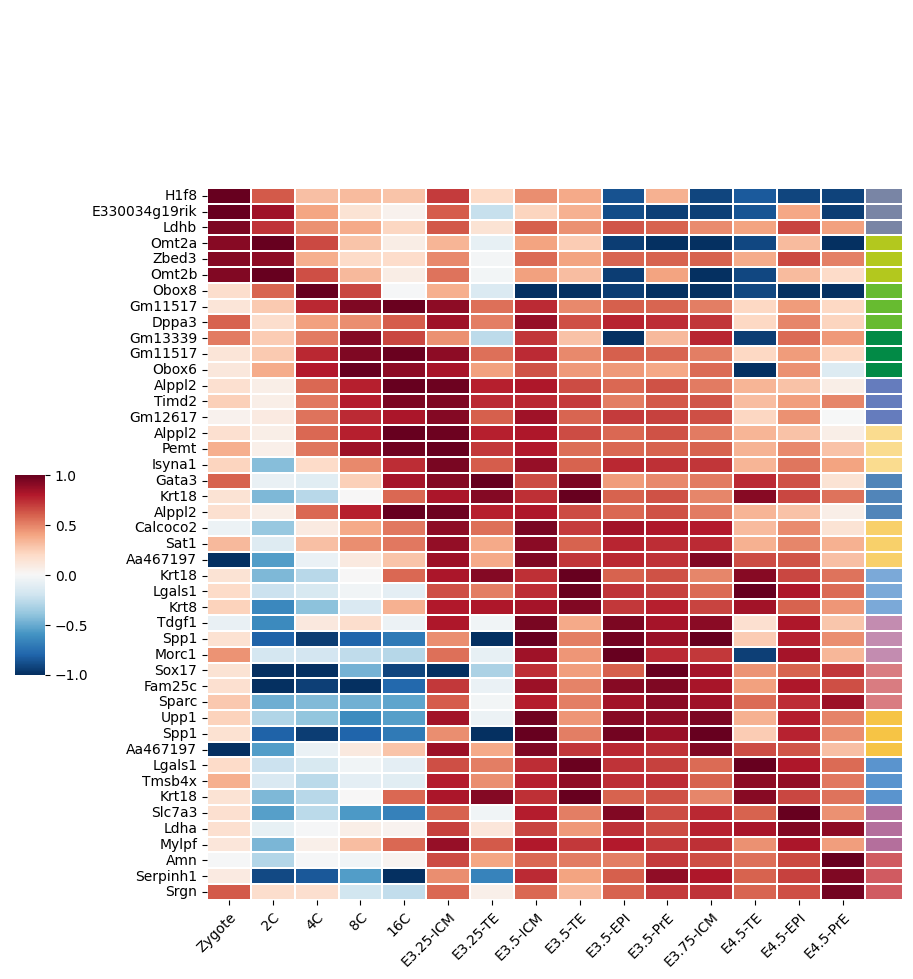

In [16]:
df_heatmap = pd.DataFrame(np.nan, 
                          index=mouse_SHAP_top_3.reset_index().feature.str.lower().values, 
                          columns=mouse.obs.ct.cat.categories)
for ct in df_heatmap.columns:
    df = sc.get.rank_genes_groups_df(mouse, group=ct).set_index('names')
    common_genes = df.index.intersection(mouse_SHAP_top_3.reset_index().feature.str.lower().values)
    df_heatmap[ct] = df.loc[common_genes, 'logfoldchanges']

g = sns.clustermap(
    pd.DataFrame(MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_heatmap.values), 
                     index=df_heatmap.index.str.capitalize(), columns=df_heatmap.columns).fillna(0),
    cmap='RdBu_r', linewidth=.3, col_cluster=False, row_cluster=False, yticklabels=True,
    row_colors=sum([[mouse_ct_colors[ct]] * 3 for ct in df_heatmap.columns], []),
    cbar_pos=(.02, .32, .03, .2), figsize=(10,10)
)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
g.ax_heatmap.tick_params(axis='y', labelright=False, labelleft=True, right=False, left=True)

ax_row_colors = g.ax_row_colors
box = ax_row_colors.get_position()
box_heatmap = g.ax_heatmap.get_position()
ax_row_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
# plt.savefig("../figures/mouse/00_SHAP_top3.svg")

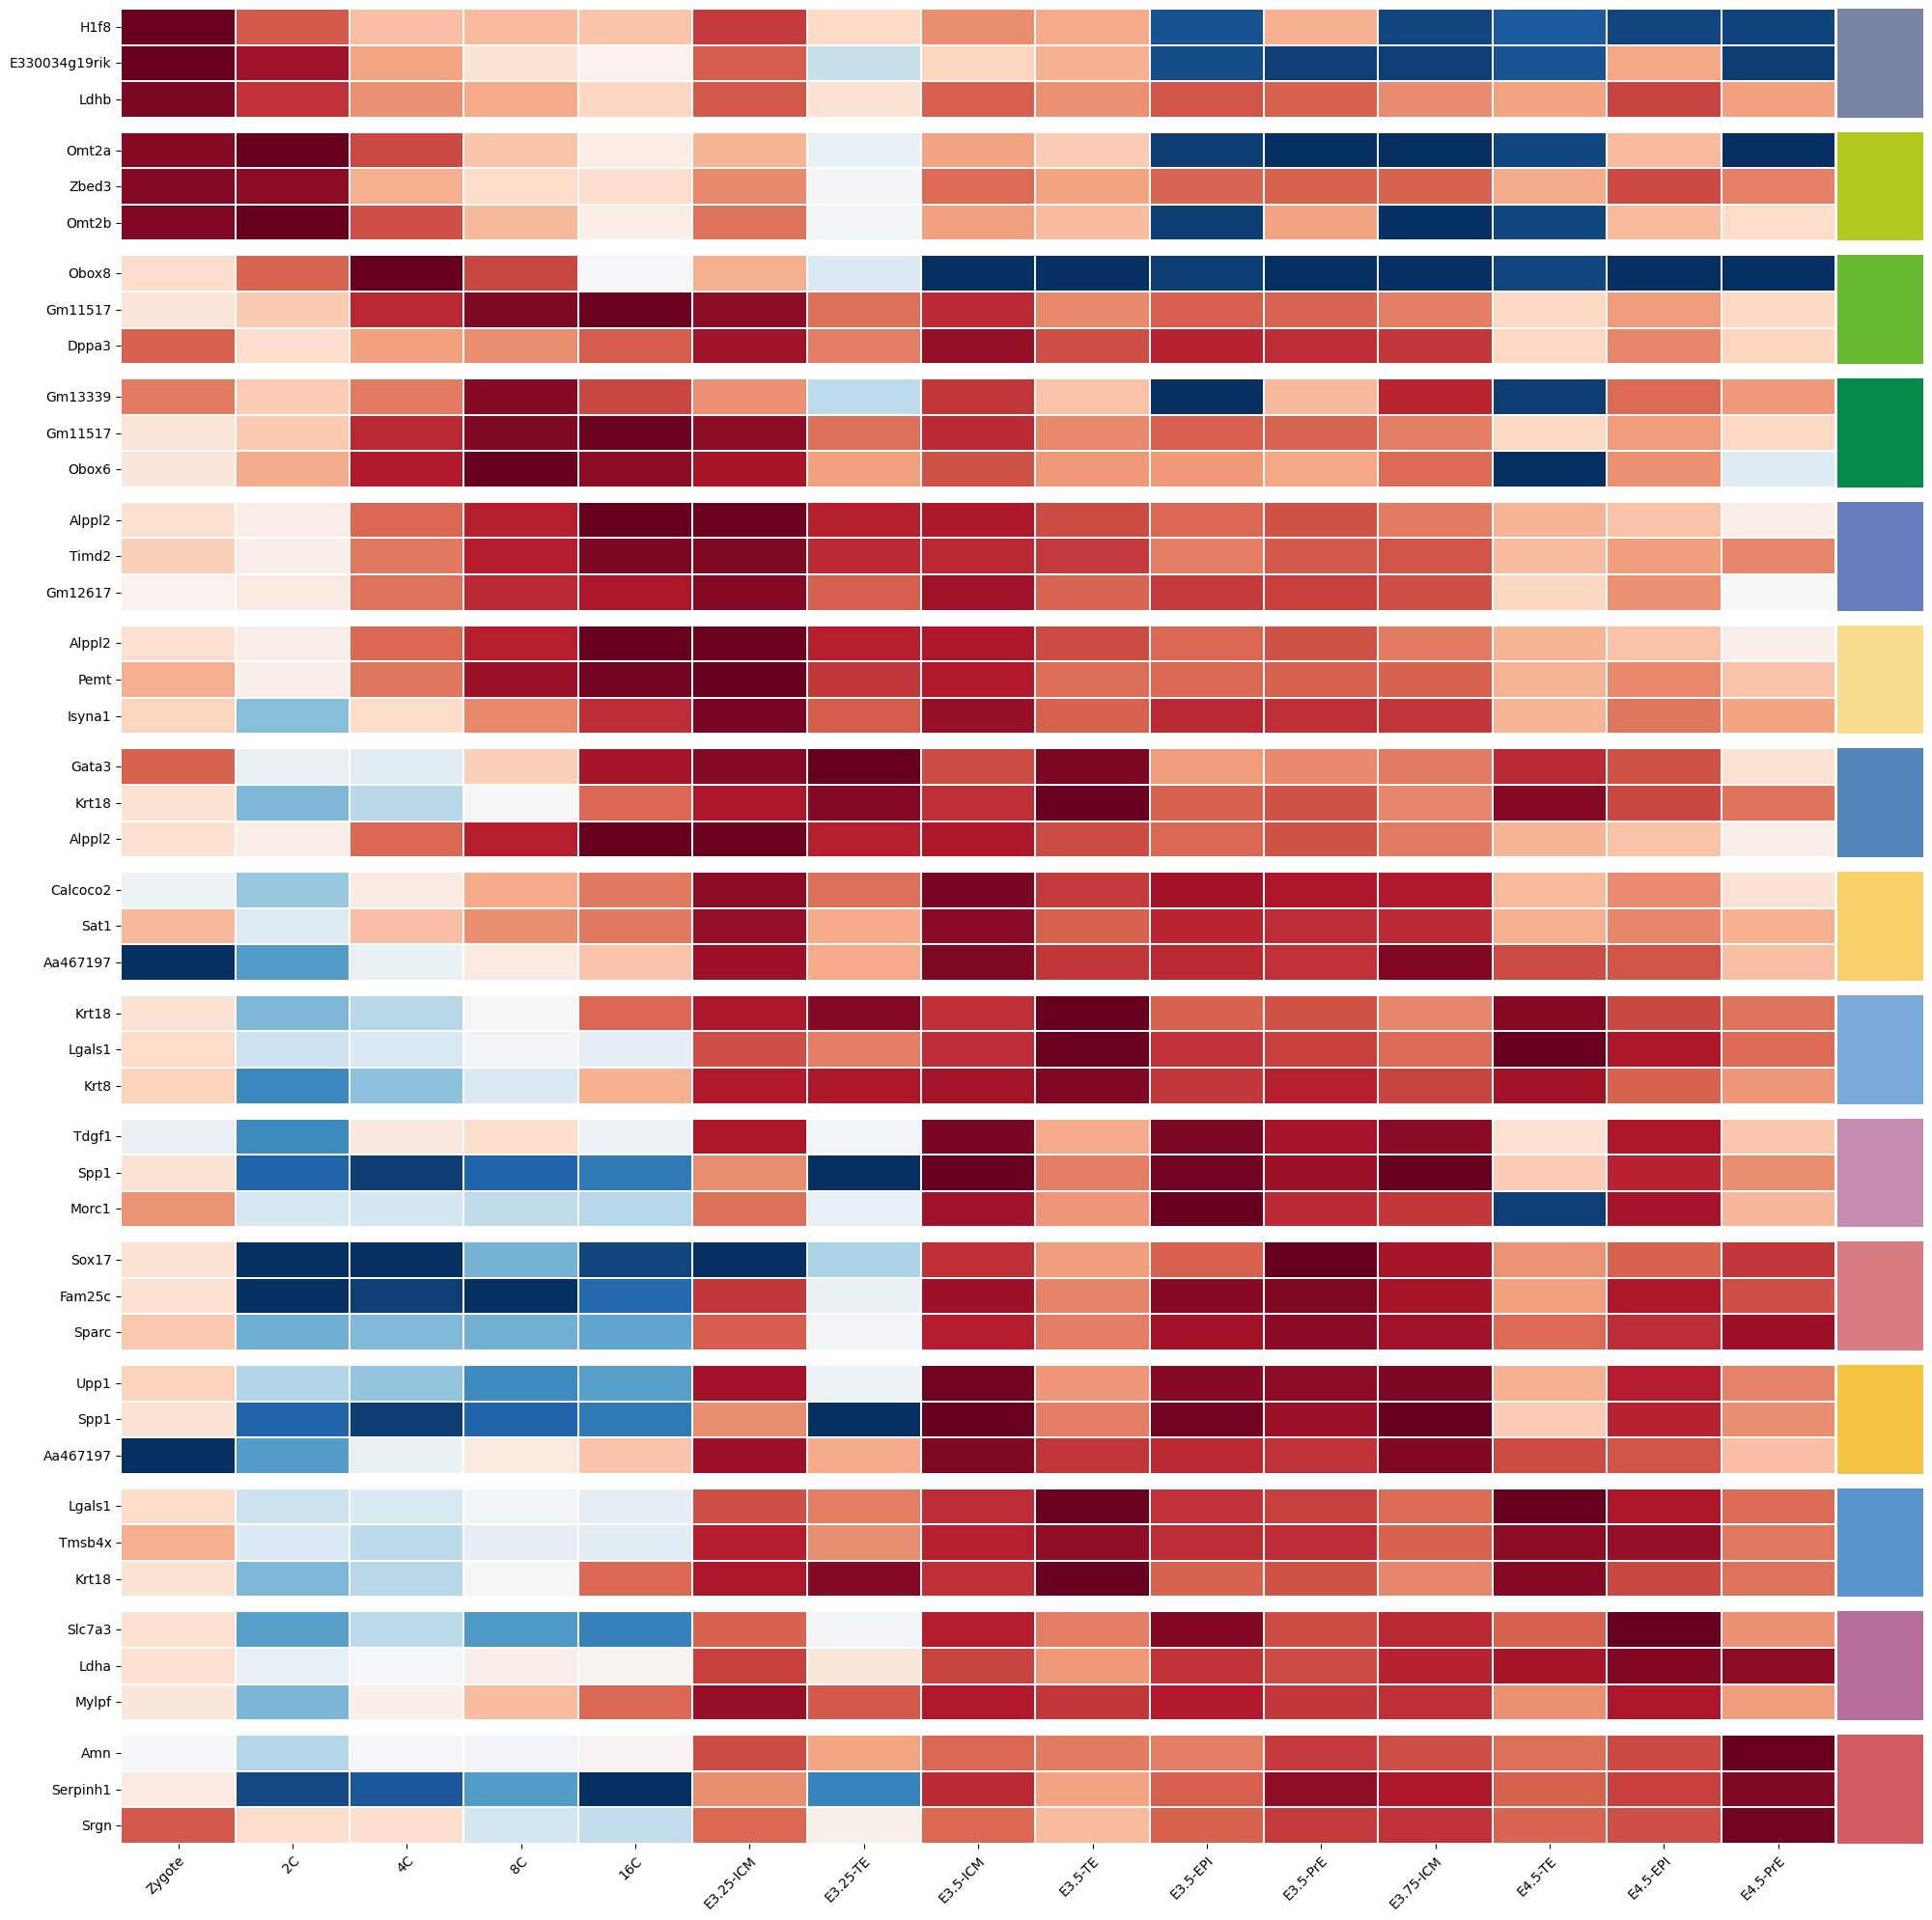

In [87]:
df_heatmap = pd.DataFrame(np.nan, 
                          index=mouse_SHAP_top_3.reset_index().feature.str.lower().values, 
                          columns=mouse.obs.ct.cat.categories)
for ct in df_heatmap.columns:
    df = sc.get.rank_genes_groups_df(mouse, group=ct).set_index('names')
    common_genes = df.index.intersection(mouse_SHAP_top_3.reset_index().feature.str.lower().values)
    df_heatmap[ct] = df.loc[common_genes, 'logfoldchanges']

df_heatmap = pd.DataFrame(
    MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_heatmap.values), 
    index=df_heatmap.index.str.capitalize(), columns=df_heatmap.columns).fillna(0)

df_heatmap['group'] = sum([[mouse_ct_colors[ct]] * 3 for ct in df_heatmap.columns], [])

n_categories = df_heatmap.shape[0] // 3
fig, ax = plt.subplots(n_categories, 1, figsize=[20,20])

for idx in range(n_categories):
    g = sns.heatmap(df_heatmap.iloc[idx*3: idx*3 + 3, :-1], cbar=None, vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[idx], xticklabels=(idx == n_categories - 1), linewidth=.3)
    for i, color in enumerate(df_heatmap.iloc[idx*3: idx*3 + 3, -1].values):
        g.add_patch(plt.Rectangle(xy=(1.001, i), width=0.05, height=1, color=color, lw=0, transform=g.get_yaxis_transform(), clip_on=False))

ax[n_categories - 1].set_xticklabels(list(df_heatmap.columns[:-1]), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()
plt.savefig("../figures/mouse/00_SHAP_top3_v2.svg")

In [ ]:
# plt.figure(figsize=(12,8))
# sns.heatmap(
#     pd.DataFrame(MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_heatmap.values), 
#                  index=df_heatmap.index, columns=df_heatmap.columns).fillna(0),
#     cmap='viridis', linewidth=.5, yticklabels=True)

# sns.clustermap(
#     df_heatmap.fillna(0), 
#     z_score=0,
#     dendrogram_ratio=(.1, .2),
#     cmap='viridis', linewidths=.5, col_cluster=False, row_cluster=False, yticklabels=True,
#     cbar_pos=(.02, .32, .03, .2), figsize=(10, 12),
#     row_colors=sum([[mouse_ct_colors[ct]] * 3 for ct in df_heatmap.columns], []))

### Human

In [88]:
lvae_human = scvi.model.SCANVI.load("../results/02_human_integration/05_scanvi_ns15/")


INFO     File ../results/02_human_integration/05_scanvi_ns15/model.pt already downloaded                           


In [89]:
# human_SHAP_scANVI = run_clf_scanvi(lvae_human, 'scANVI_human', n=10, groupby='C_scANVI_nsamples')
# human_SHAP_scANVI.reset_index(drop=True).to_feather("../results/00_human_scANVI_deepexplainer.feather")
human_SHAP_scANVI = pd.read_feather("../results/00_human_scANVI_deepexplainer.feather")

human.uns['log1p'] = {'base': None}
sc.tl.rank_genes_groups(human, groupby='C_scANVI_nsamples', n_genes=-1)

human_SHAP_all = filter_SHAP("../results/00_human_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(-1)\
    .reset_index()\
    .assign(feature = lambda x: x.feature.str.upper())\
    .set_index(['ct', 'feature'])\
    .loc[human.obs.C_scANVI_nsamples.cat.categories]

human_SHAP_top_3 = filter_SHAP("../results/00_human_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(3)\
    .reset_index()\
    .assign(feature = lambda x: x.feature.str.upper())\
    .set_index(['ct', 'feature'])\
    .loc[human.obs.C_scANVI_nsamples.cat.categories]

In [90]:
# human_SHAP_top_3 = human_SHAP_top_3.reset_index()
# human_SHAP_top_3.feature = ENSG_to_SYMBOL.loc[human_SHAP_top_3.feature.str.upper(), 'symbol'].values
# human_SHAP_top_3 = human_SHAP_top_3.set_index(['ct', 'feature'])

In [ ]:
df_heatmap = pd.DataFrame(np.nan, 
                          index=human_SHAP_top_3.reset_index().feature.str.upper().values, 
                          columns=human.obs.C_scANVI_nsamples.cat.categories)
for ct in df_heatmap.columns:
    df = sc.get.rank_genes_groups_df(human, group=ct).set_index('names')
    common_genes = df.index.intersection(human_SHAP_top_3.index.get_level_values(1))
    df_heatmap[ct] = df.loc[common_genes, 'logfoldchanges']

g = sns.clustermap(
    pd.DataFrame(MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_heatmap.values), 
                     index=get_symbol(df_heatmap.index), columns=df_heatmap.columns).fillna(0),
    cmap='RdBu_r', linewidth=.3, col_cluster=False, row_cluster=False, yticklabels=True,
    row_colors=sum([[human_ct_colors[ct]] * 3 for ct in df_heatmap.columns], []),
    cbar_pos=(.02, .32, .03, .2), figsize=(10,10)
)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
g.ax_heatmap.tick_params(axis='y', labelright=False, labelleft=True, right=False, left=True)

ax_row_colors = g.ax_row_colors
box = ax_row_colors.get_position()
box_heatmap = g.ax_heatmap.get_position()
ax_row_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
plt.savefig("../figures/human/00_SHAP_top3.svg")

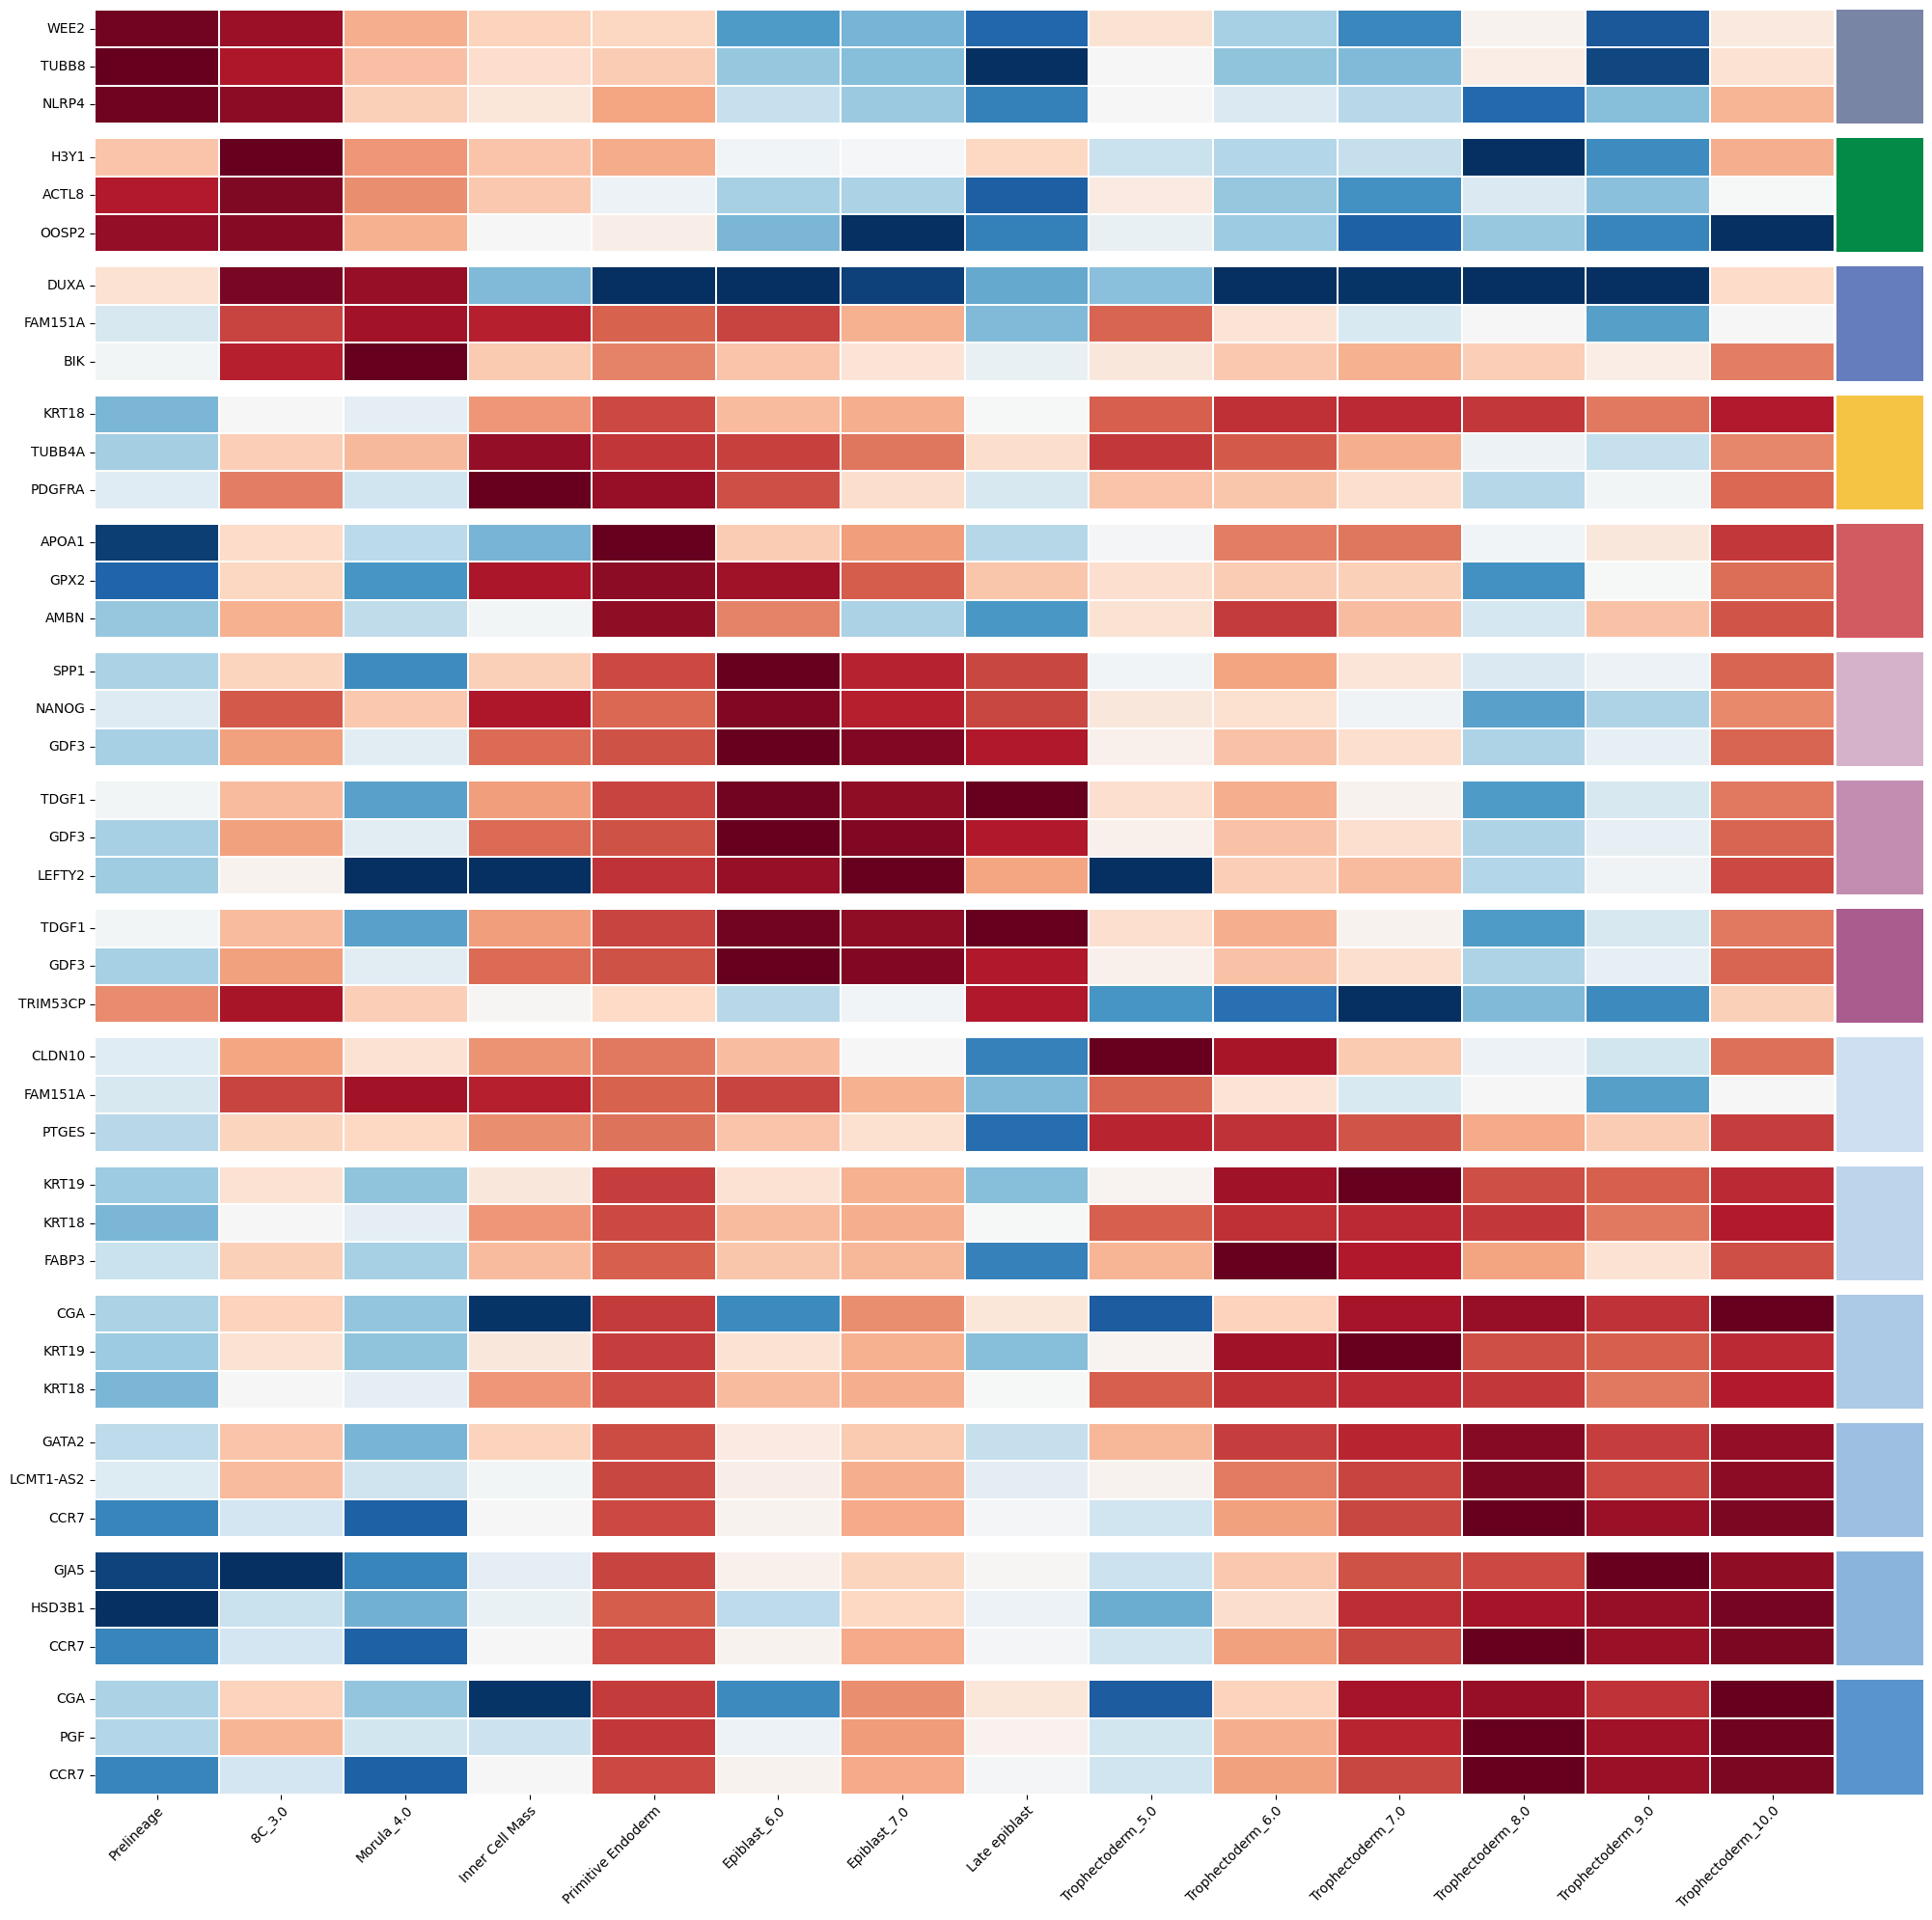

In [96]:
df_heatmap = pd.DataFrame(np.nan, 
                          index=human_SHAP_top_3.reset_index().feature.str.upper().values, 
                          columns=human.obs.C_scANVI_nsamples.cat.categories)
for ct in df_heatmap.columns:
    df = sc.get.rank_genes_groups_df(human, group=ct).set_index('names')
    common_genes = df.index.intersection(human_SHAP_top_3.index.get_level_values(1))
    df_heatmap[ct] = df.loc[common_genes, 'logfoldchanges']

df_heatmap = pd.DataFrame(
    MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_heatmap.values), 
    index=get_symbol(df_heatmap.index), columns=df_heatmap.columns).fillna(0)

df_heatmap['group'] = sum([[human_ct_colors[ct]] * 3 for ct in df_heatmap.columns], [])

n_categories = df_heatmap.shape[0] // 3
fig, ax = plt.subplots(n_categories, 1, figsize=[20,20])

for idx in range(n_categories):
    g = sns.heatmap(df_heatmap.iloc[idx*3: idx*3 + 3, :-1], cbar=None, vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[idx], xticklabels=(idx == n_categories - 1), linewidth=.3)
    for i, color in enumerate(df_heatmap.iloc[idx*3: idx*3 + 3, -1].values):
        g.add_patch(plt.Rectangle(xy=(1.001, i), width=0.05, height=1, color=color, lw=0, transform=g.get_yaxis_transform(), clip_on=False))

ax[n_categories - 1].set_xticklabels(list(df_heatmap.columns[:-1]), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()
plt.savefig("../figures/human/00_SHAP_top3_v2.svg")

### Suppl Table 4

In [ ]:
mouse_SHAP_all = filter_SHAP("../results/00_mouse_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(-1)\
    .reset_index()\
    .set_index(['ct', 'feature'])\
    .loc[mouse.obs.ct.cat.categories]

human_SHAP_all = filter_SHAP("../results/00_human_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(-1)\
    .reset_index()\
    .assign(feature = lambda x: x.feature.str.upper())\
    .set_index(['ct', 'feature'])\
    .loc[human.obs.C_scANVI_nsamples.cat.categories]\
    .assign(symbol = get_symbol(human_SHAP_all.index.get_level_values(1)))

In [ ]:
writer = pd.ExcelWriter("../results/suppl-tab-4.xlsx", engine="xlsxwriter")
mouse_SHAP_all.reset_index().to_excel(writer, sheet_name="mouse")
human_SHAP_all.reset_index().to_excel(writer, sheet_name="human")
writer.close()

## Diff. expressed genes

In [ ]:
def filter_markers(df: pd.DataFrame, n_genes: int = 5, upper: bool = False):
    # significant only
    df = df[
        (df["is_de_fdr_0.05"])
        & (df["bayes_factor"] > 3)
        & (df["non_zeros_proportion1"] > 0.1)
        & (df["lfc_median"] > 0)
    ]
    comparisons = df.comparison.unique()

    deg_df = {}
    for comparison in comparisons:
        cluster = comparison.split(" ")[0]
        markers = (
            df.query("comparison == @comparison")
            .sort_values(by="lfc_median", ascending=False)
            .head(n_genes)
        )
        deg_df[cluster] = (
            markers.index.str.upper().tolist() if upper else markers.index.tolist()
        )

    return deg_df

In [ ]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")
m_ct = vae.differential_expression(groupby="ct")
m_ct_filt = filter_markers(m_ct, n_genes=100)
pd.DataFrame.from_dict(m_ct_filt, orient='index').transpose().to_csv("../results/00_mouse_ct_markers.csv")

In [ ]:
m_ct = vae.differential_expression(groupby="stage")
m_ct_filt = filter_markers(m_ct, n_genes=10)
pd.DataFrame.from_dict(m_ct_filt, orient='index').transpose().to_csv("../results/00_mouse_stage_markers.csv")

## Suppl. Table 5 [query]

In [ ]:
writer = pd.ExcelWriter("../results/suppl-tab-5.xlsx", engine="xlsxwriter")
pd.read_csv("../results/00_mouse_query.csv", index_col=0).to_excel(writer, sheet_name="Mouse invitro")
pd.read_csv("../results/00_human_query.csv", index_col=0).to_excel(writer, sheet_name="Human invitro")
writer.close()

## Suppl. Fig. 4

In [ ]:
mouse_SHAP_top_3 = filter_SHAP("../results/00_mouse_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(3)\
    .reset_index()\
    .set_index(['ct', 'feature'])\
    .loc[mouse.obs.ct.cat.categories]

human_SHAP_top_3 = filter_SHAP("../results/00_human_scANVI_deepexplainer.feather")\
    .sort_values('weight_mean', ascending=False)\
    .groupby('ct')\
    .head(3)\
    .reset_index()\
    .assign(feature = lambda x: x.feature.str.upper())\
    .set_index(['ct', 'feature'])\
    .loc[human.obs.C_scANVI_nsamples.cat.categories]

In [ ]:
cats = mouse.obs.ct.cat.categories
fig, ax = plt.subplots(5, 3, figsize=(11.69,8.27))

for idx, ct in enumerate(cats):
    df = mouse_SHAP_top_3.loc[mouse_SHAP_top_3.index.get_level_values(0) == ct].reset_index().set_index('feature').sort_values(by='weight_mean', ascending=True)
    df['weight_mean'].plot.barh(ylabel=ct, color=mouse_ct_colors[ct], ax=ax[idx // 3, idx % 3])
    ax[idx // 3, idx % 3].errorbar(df['weight_mean'], df.index, xerr=df['weight_std'], color="black", capthick=2, elinewidth=2,capsize=2, yerr = None, ls='none')
fig.tight_layout()
fig.savefig("../figures/mouse/00_SHAP_top3_bar.svg")

In [ ]:
cats = human.obs.C_scANVI_nsamples.cat.categories
fig, ax = plt.subplots(5, 3, figsize=(11.69,8.27))

for idx, ct in enumerate(cats):
    df = human_SHAP_top_3.loc[human_SHAP_top_3.index.get_level_values(0) == ct].reset_index().set_index('feature').sort_values(by='weight_mean', ascending=True)
    df.index = get_symbol(df.index)
    df['weight_mean'].plot.barh(ylabel=ct, color=human_ct_colors[ct], ax=ax[idx // 3, idx % 3])
    ax[idx // 3, idx % 3].errorbar(df['weight_mean'], df.index, xerr=df['weight_std'], color="black", capthick=2, elinewidth=2,capsize=2, yerr = None, ls='none')
fig.tight_layout()
fig.savefig("../figures/human/00_SHAP_top3_bar.svg")

## XGBoost vs scANVI

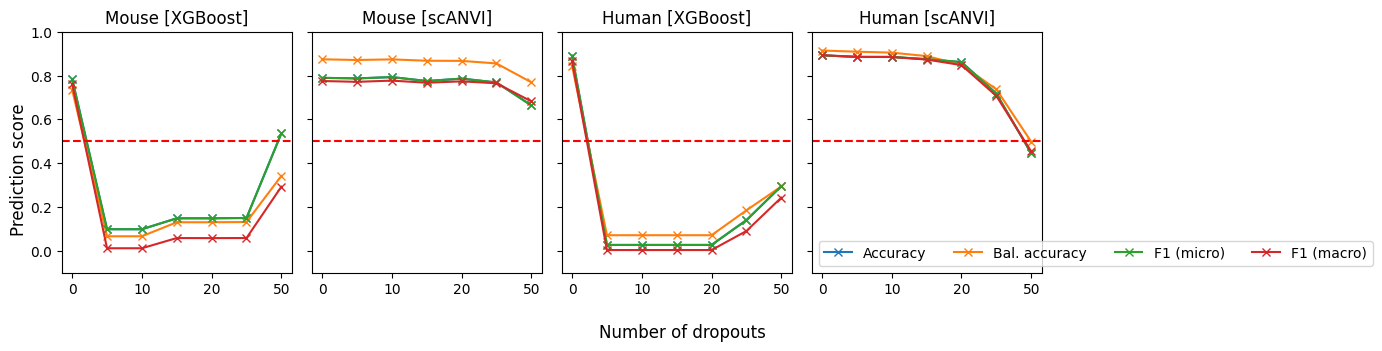

In [28]:
stats = pd.read_excel("../results/suppl-tab-3.xlsx", index_col=0)

fig, ax = plt.subplots(1, 4, figsize=[14, 3.5], sharey=True, sharex=True)

stats.query('clf == "XGBoost" & species == "mouse"').plot.line(marker='x', ylim=(-0.1,1), title='Mouse [XGBoost]', legend=None, ax=ax[0])
stats.query('clf == "scANVI" & species == "mouse"').plot.line(marker='x', ylim=(-0.1,1), title='Mouse [scANVI]', legend=None, ax=ax[1])
stats.query('clf == "XGBoost" & species == "human"').plot.line(marker='x', ylim=(-0.1,1), title='Human [XGBoost]', legend=None, ax=ax[2])
stats.query('clf == "scANVI" & species == "human"').plot.line(marker='x', ylim=(-0.1,1), title='Human [scANVI]', legend=None, ax=ax[3])

for i in range(4):
    ax[i].set_xticklabels(['', '0', '10', '20', '50', '100', '200', '500'])
    ax[i].axhline(0.5, c='r', ls='--')

ax[3].legend(('Accuracy','Bal. accuracy', 'F1 (micro)', 'F1 (macro)'), ncol=4)

fig.supxlabel('Number of dropouts')
fig.supylabel('Prediction score')
fig.tight_layout()
fig.savefig('../figures/00_xgboost_vs_scanvi_v2.svg')